In [1]:
import torch

import numpy as np

from PIL import Image
from lavis.models import load_model_and_preprocess
from lavis.models.blip_diffusion_models.utils import preprocess_canny

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.8/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


In [2]:
torch.cuda.is_available()

True

In [3]:
model, vis_preprocess, txt_preprocess = load_model_and_preprocess(
    "blip_diffusion", "canny", device="cuda", is_eval=True)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/opt/conda/lib/python3.8/site-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality

No ctx_embeddings_cache found in /export/share/dongxuli/zerobooth/500000-renamed/


In [4]:
def generate_canny(cond_image_input, low_threshold, high_threshold):
    # convert cond_image_input to numpy array
    cond_image_input = np.array(cond_image_input).astype(np.uint8)

    # canny_input, vis_control_image = preprocess_canny(cond_image_input, 512, low_threshold=100, high_threshold=200)
    vis_control_image = preprocess_canny(cond_image_input, 512, low_threshold=low_threshold, high_threshold=high_threshold)

    return vis_control_image 

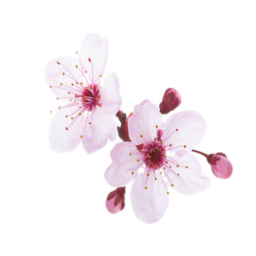

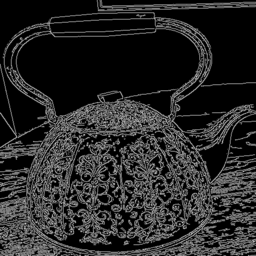

In [5]:
src_subject = "flower"
tgt_subject = "teapot"

prompt = "on a marble table"

src_subjects = [txt_preprocess["eval"](src_subject)]
tgt_subjects = [txt_preprocess["eval"](tgt_subject)]
prompt = [txt_preprocess["eval"](prompt)]

cond_image = Image.open("../images/kettle.jpg").convert("RGB")

input_image = Image.open("../images/flower.jpg").convert("RGB")
display(input_image.resize((256, 256), resample=Image.BILINEAR))
input_image = vis_preprocess["eval"](input_image).unsqueeze(0).cuda()

canny_low_threshold = 30
canny_high_threshold = 70

cond_image_input = generate_canny(cond_image, canny_low_threshold, canny_high_threshold)

cond_image_display = cond_image_input.resize((256, 256), resample=Image.BILINEAR)
display(cond_image_display)

In [6]:
samples = {
    "input_images": input_image,
    "src_subject": src_subjects,
    "tgt_subject": tgt_subjects,
    "prompt": prompt,
    "cond_image": cond_image_input.convert("RGB"),
}

Computing BLIP embeddings for 1 subjects


/export/home/workspace/LAVIS-Diffusion/LAVIS/lavis/models/blip_diffusion_models/blip_diffusion.py:277: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents_shape = (1, self.unet.in_channels, height // 8, width // 8)
100%|██████████| 51/51 [00:07<00:00,  7.20it/s]


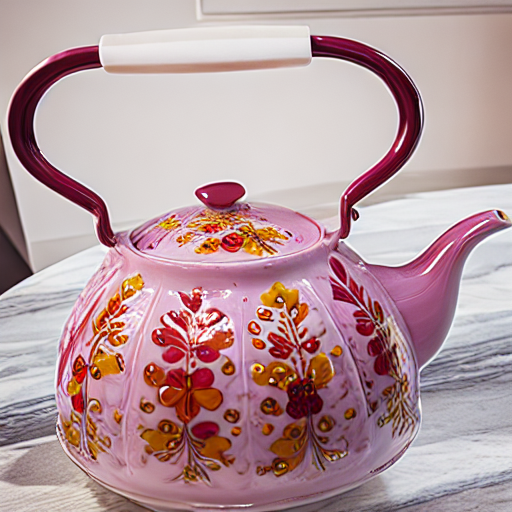

In [7]:
iter_seed = 88888
guidance_scale = 7.5
num_inference_steps = 50
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

output = model.generate(
    samples,
    seed=iter_seed,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    neg_prompt=negative_prompt,
    height=512,
    width=512,
)

display(output[0])
